### Facsimile inversion 

In [1]:
import numpy as np
import itertools as it
import sys
sys.path.append('../Comm/')
from utils import iterative_solve_eta as itsol
from utils import iterative_solve_Q as itsolQ
from utils import create_random_Q0
import matplotlib.pyplot as plt
from scipy.special import softmax

## Solve eta $\eta$

The value of $\eta$ is obtained by solving the following equation:
$$
\eta = \left( 1 - \gamma T \right)^{-1} \rho
$$

Where $\rho$ is given by the process and $T$ is building as follows:
$$
T(s',m'|s,m) = \sum_{a,y}\, p(s'|s,a)\, \pi(a,m'|m,y)\, f(y|s)
$$

In [2]:
clip = lambda x, l, u: l if x < l else u if x > u else x

def solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range):
    """
    This function should solve the following:
    --> New_eta = (1 - gamma T)^-1 rho
    """
    
    O, M, A = pi.shape
    L = Lx * Ly
    new_eta = np.zeros(M*L)
    
    # PY has size ~ 10^5
    PY = PObs_lim.reshape(O, M, Ly, Lx)
    # PY has size ~ 10^2
    PAMU = pi.reshape(O, M, M, A//M)
    
    p_a_mu_m_xy = np.einsum( 'omyx, omna -> anmyx', PY, PAMU)
    # T [ s'm'  sm] = sum_a, mu p(s'm' | sm a mu) p(a mu | sm)
    #               = sum_a, mu p(s'm' | sm a mu) sum_y f(y | s) pi(a mu | y m)
    
    print(p_a_mu_m_xy.shape)
    
    # Tsm_sm has size ~ 10^5 x 10^5 or more
    Tsm_sm = np.zeros( (M, Ly, Lx, M, Ly, Lx) )
    
    # Action Order
    # left, right, up, down
    
    # tuples to be populated
    #      T indices : "left / right / up / down"
    #      (m', y', x', m, y, x)
    #      pi indices : "left_act / ... "
    #      (m', a, m, y, x)
    for im_new in range(M):
        
        left = [ (im_new, iy, clip(ix-1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        left_act = [ (0, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        
        for l, la in zip(left, left_act):
            Tsm_sm[l] += p_a_mu_m_xy[la]
        
        right = [ (im_new, iy, clip(ix+1, 0, Lx-1), im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        right_act = [ (1, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for r, ra in zip(right, right_act):
            Tsm_sm[r] += p_a_mu_m_xy[ra]
    
        up = [ (im_new, clip(iy+1, 0, Ly-1), ix,  im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        up_act = [ (2, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for u, ua in zip(up, up_act):
            Tsm_sm[u] += p_a_mu_m_xy[ua]
        
        down = [ (im_new, clip(iy-1, 0, Ly-1), ix, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        down_act = [ (3, im_new, im, iy, ix)   for ix in np.arange(Lx) for iy in np.arange(Ly) for im in np.arange(M)]
        for d, da in zip(down, down_act):
            Tsm_sm[d] += p_a_mu_m_xy[da]
    
    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)
    
    All = slice(None)
    for yx_found in yx_founds:
        ls = (All, yx_found[0], yx_found[1], All, All, All)
        # all transitions starting from the source do not go anywhere
        Tsm_sm[ls] = 0
        # all transitions ending in the source stop the episode
        ls = (All, All, All, All, yx_found[0], yx_found[1])
        Tsm_sm[ls] = 0
    
    Tsm_sm_matrix = np.reshape(Tsm_sm, (M*Ly*Lx, M*Ly*Lx))
    to_invert = np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix
    inverted = np.linalg.inv(to_invert)
    new_eta = inverted @ rho0
    
    return new_eta, Tsm_sm_matrix

## Solve Q 
The value of $Q$ is the following:
$$
Q(s,m,a,m')= \sum_{s'}\, p(s'|s,a)\, \mathbb{1}(s'\neq x_s)\,(\gamma V(s',m')-1\,)
$$

First we need to find $V$ solving the linear system:
$$
\begin{align*}
V^{T} &= r^{T}(1-\gamma T)^{-1} \\
V^{T}(1-\gamma T)  &= r^{T} \\
(1-\gamma T^{T})V  &= r \\
\end{align*}
$$
Where $r$ is the reward vector, $T$ is the transition matrix and $\gamma$ is the discount factor.

The reward vector is:
$$
r(s,m) = -(1-\gamma) \sum_{a,s',y}\, p(s'|s,a)\, f(y|s) \, \pi_\theta (a,m'|m,y)\, \mathbb{1}(x'\neq x_s) 
$$


## Questions:
Why in the paper the T matrix looks like same for solve Q and eta?

Why the average rewards from Fortran have a lot of dimensions (M,Lx,Ly,A,M)?

Is the same average reward that you get from Fortran and the paper?

First we need to compute V, make the inversion, and after build Q?

What is the difference between m' and mu?

What is PY  and PAMU in the code?

## New set of questions:

Why when build T matrix exclude the source point? In the paper is not excluded.

To build the reward vector, Could I take the T matrix and sum over s' and m' for each s and m after discard the source and multiply by 1-gamma?
$$
r(s,m) = -(1-\gamma) \sum_{s',m'}\, T(s',m'|s,m) \mathbb{1}(x'\neq x_s)
$$

When is solved the linear system, the V(s,m) becomes to V(s',m')?

## New New set of questions:

Is necessary to include the reward find in the building of average reward vector?

Is the same restriction $1(s' \neq x_s)$ and $1(x' \neq x_s)$

In Q vector, m and m' are the same?

How make the sum over s' in Q vector?

## New New New set of questions:

Why if I omit the -1 in the Q vector, the results are better?

## $\text{New}^4$ set of questions:
Why is necessary to put pi to zero to have the same values?

## Set of actions

In [3]:
def action_move(action):
    """
    This function returns the move from the action
    """
    if action == 0:   # left
        move = np.array([0, -1])
    elif action == 1: # right
        move = np.array([0, 1])
    elif action == 2: # up
        move = np.array([1, 0])
    elif action == 3: # down
        move = np.array([-1, 0])
    elif action == 4: # upper left
        move = np.array([1, -1])
    else:
        print('Error: action not recognized')
        move = np.array([0, 0])
    return move

def get_next_state(state : np.ndarray, action : int, move = None):

    if move is None :
        move = action_move(action)

    n_rolls = [0,0]

    clipped_x = []
    dataClipped_x = None
    clipped_y = []
    dataClipped_y = None

    # Complex move
    if move[0] != 0 and move[1] != 0 :
        state = get_next_state(state,-1,move=[0,move[-1]])
        state = get_next_state(state,-1,move=[move[-2],0])

    # move in x
    elif move[-1] != 0 : 
        col = move[-1]
        if col < 0 :
            data2clip = np.s_[:,0]
            clipped_x = [i for i in range(-col)]
        else :
            data2clip = np.s_[:,-1]
            clipped_x = [-i for i in range(1,col+1)]

        dataClipped_x = state[data2clip].copy()

        n_rolls[-1] = -col

    # move in y 
    elif move[-2] != 0 : 
        row = move[-2]
        if row < 0 :
            data2clip = np.s_[0,:]
            clipped_y = [i for i in range(-row)]
        else :
            data2clip = np.s_[-1,:]
            clipped_y = [-i for i in range(1,row+1)]

        dataClipped_y = state[data2clip].copy()

        n_rolls[-2] = -row

    ## move in z

    state = np.roll(state,n_rolls,axis=(0,1))

    for i in clipped_y :
        state[i,:] = dataClipped_y
    for i in clipped_x :
        state[:,i] = dataClipped_x

    return state

# tmp = np.arange(5*7).reshape(7,5)
# mask_source = [(4,2),(3,2),(5,2),(4,1),(4,3)]
# for i in mask_source :
#     tmp[i] = 0
# tmp[4,2] = -1
# print("Initial \n",tmp)
# output = get_next_state(tmp,0)
# print("Final\n",output)

# print("Mask the source")
# for i in mask_source :
#     output[i] = 0
# print("Masked\n",output)


In [4]:
def average_reward(Tsm_sm_matrix, M, Lx, Ly, cost_move,source_as_zero):
    """
    This function compute the average reward from the Transition matrix T
    The dimension of RR is (M, Ly, Lx)
    """
    # Tsm_sm = Tsm_sm_matrix.reshape(M, Ly, Lx, M, Ly, Lx)
    # RR_T = -cost_move * Tsm_sm.sum(axis=(0,1,2))
    # return RR_T

    RR = np.full((M, Ly, Lx),-cost_move)
    RR[:,source_as_zero[:,0],source_as_zero[:,1]] = 0.0

    return RR

def solve_Q(Tsm_sm_matrix, Lx, Ly, Lx0, Ly0, M, A, gamma,find_range):

    yxs = it.product(np.arange(Ly), np.arange(Lx))
    yx_founds = it.filterfalse(lambda x: (x[0]-Ly0)**2 + (x[1]-Lx0)**2 > find_range**2, yxs)
    source_as_zero = np.array([i for i in yx_founds])

    cost_move = 1.0 - gamma
    reward = average_reward(Tsm_sm_matrix, M, Lx, Ly, cost_move,source_as_zero)

    reward = reward.reshape(M*Ly*Lx)

    Tsm_sm_matrix = Tsm_sm_matrix.transpose()

    V = np.linalg.solve(np.eye(M*Ly*Lx) - gamma * Tsm_sm_matrix, reward)

    V = gamma * V 
    # V = gamma * V - 1.0

    V = V.reshape(M, Ly, Lx)

    state = np.empty((Ly, Lx))

    Q = np.zeros((Ly, Lx, M, A))
    for im in range(M):
        for a in range(A):
            state[:,:] = V[im,:,:]
            new_state = get_next_state(state, a)
            new_state = new_state - cost_move
            new_state[source_as_zero[:,0],source_as_zero[:,1]] = 0
            Q[:,:,im, a] = new_state

    Q = np.repeat(Q[np.newaxis,:,:,:,:], M,axis=0)
            
    return V, Q

## Compute the reward vector $r$

In [5]:
def action_move_0(x,y,a):
    if a == 0:
        return x+1,y
    if a == 1:
        return x-1,y
    if a == 2:
        return x,y-1
    if a == 3:
        return x,y+1
    if a == 4:
        return x,y
    
def average_reward_fortran(Lx,Ly,M,A,Lx0,Ly0,find_range,cost_move,reward_find):
    """
    Lx,Ly: size of the grid
    M: number of memory states
    A: number of actions
    Lx0,Ly0: location of the agent
    find_range: range of the agent's sensor
    cost_move: cost of moving
    reward_find: reward for finding the source

    Returns:
    RR_np: average reward matrix
    
    """
    
    RR_np = np.ones((Ly,Lx,A)) * (- cost_move)
    # Set zero inside of the source area
    radius = find_range**2
    y_range = (int(Ly0-radius)-2,int(Ly0+radius)+2)
    x_range = (int(Lx0-radius)-2,int(Lx0+radius)+2)

    # print("radius",radius,"y_range",y_range,"x_range",x_range)

    for i in range(y_range[0],y_range[1]):
        for j in range(x_range[0],x_range[1]):
            if (i-Ly0)**2 + (j-Lx0)**2 < radius:
                for a in range(A):
                    x,y = action_move_0(j,i,a)
                    RR_np[y,x,a] += reward_find

    for i in range(y_range[0],y_range[1]):
        for j in range(x_range[0],x_range[1]):
            if (i-Ly0)**2 + (j-Lx0)**2 < radius:
                RR_np[i,j,:] = 0.0

    RR_np = np.tile(RR_np, M)
    RR_np = RR_np.reshape(Ly,Lx,M,A)
    RR_np = np.repeat(RR_np[np.newaxis,:,:,:,:], M,axis=0)
    # RR_np = RR_np.flatten()

    return RR_np


## TEST

(4, 2, 2, 15, 11)


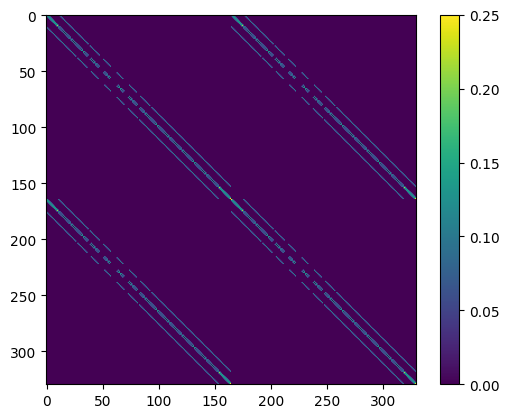

In [6]:
M = 2
O = 2
Lx = 11
Ly = 15
a_size = 4
gamma = 0.95
find_range = 2.1
tol = 1e-8

# Average reward
cost_move = 1-gamma
# reward_find = cost_move * 0.8
reward_find = 0.0

np.random.seed(33)

# pi = softmax( np.random.rand(O,M,M*a_size), 2)
pi = softmax( np.zeros((O,M,M*a_size)), 2)

PObs_lim = np.random.rand(O, M*Lx*Ly)
PObs_lim[1] = 1-PObs_lim[0]
Lx0 = Lx // 2
Ly0 = Ly // 3
rho0 = np.random.rand(M*Lx*Ly)
rho0[Lx:] = 0
rho0 /= np.sum(rho0)
eta0 = np.random.rand(M*Lx*Ly)

# Solve eta
inv_sol, T = solve_eta(pi, PObs_lim, gamma, rho0, Lx, Ly, Lx0, Ly0, find_range)
iter_sol = itsol(pi, PObs_lim, gamma, rho0, eta0, tol, Lx, Ly, Lx0, Ly0, find_range)
plt.imshow(T)
plt.colorbar()
plt.show()


V shape (2, 15, 11)


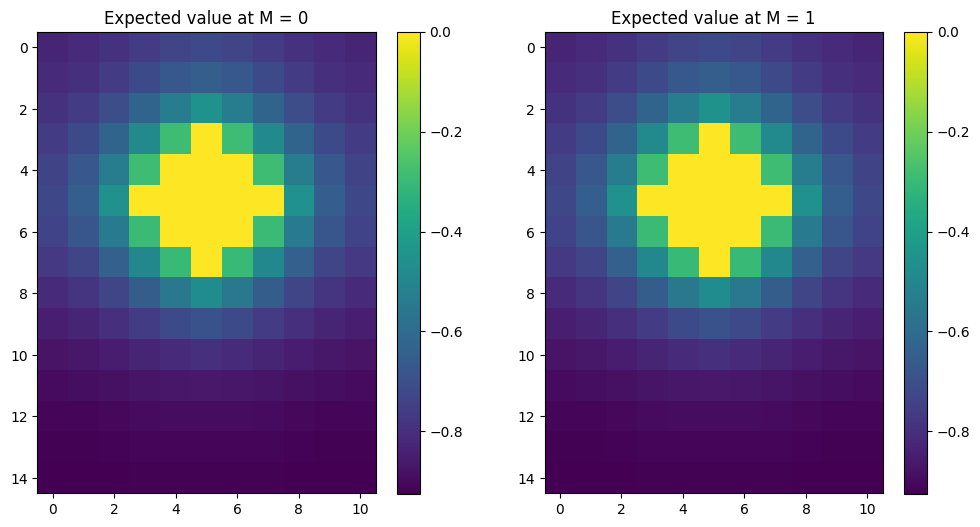

Q shape (2, 15, 11, 2, 4)


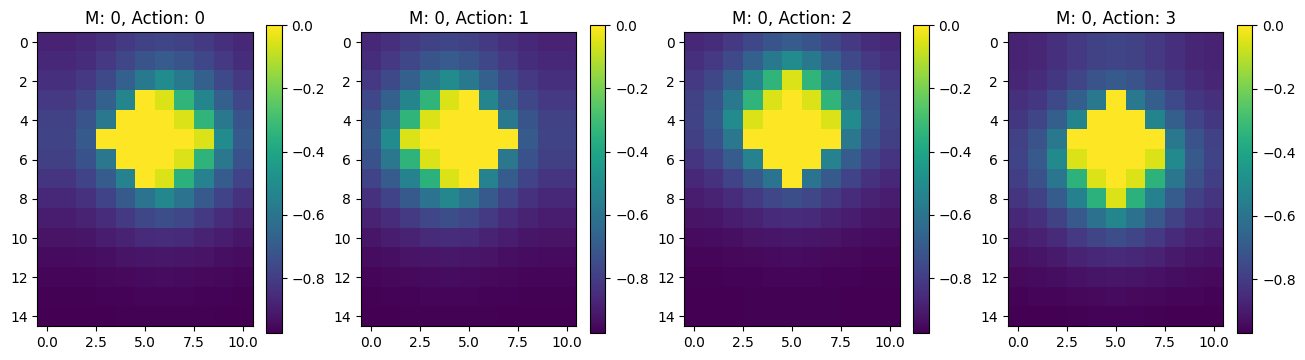

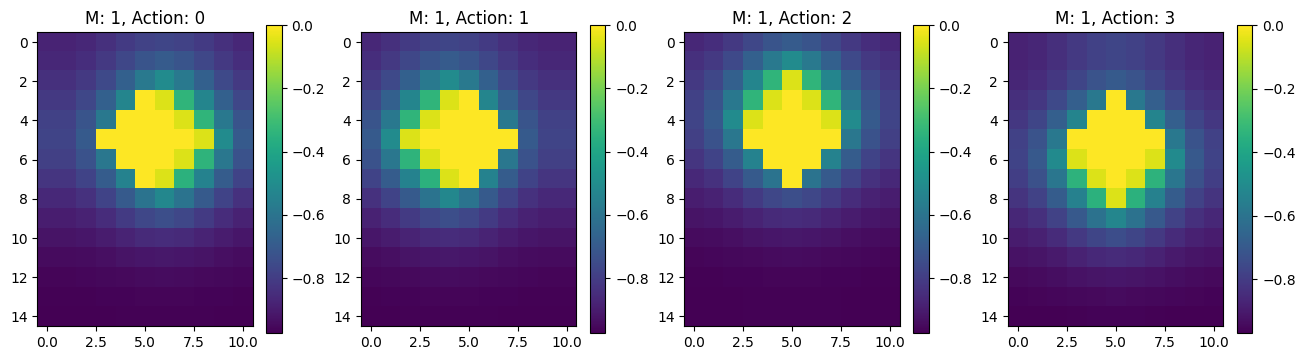

Diff between Q in memory state 0 and 1
Action: 0 2.3425705819590803e-14
Action: 1 2.248201624865942e-14
Action: 2 2.403632848313464e-14
Action: 3 2.220446049250313e-14


In [7]:

# Solve Q

V, Q = solve_Q(T, Lx, Ly, Lx0, Ly0, M, a_size, gamma, find_range)
print('V shape', V.shape)
fig = plt.figure(figsize=(12,6))
for i in range(M):
    plt.subplot(1,M,i+1)
    plt.title("Expected value at M = {}".format(i))
    plt.imshow(V[i,:,:])
    plt.colorbar()
plt.show()

print('Q shape', Q.shape)
for i in range(M):
    fig = plt.figure(figsize=(16,4))
    for j in range(a_size):
        plt.subplot(1,a_size,j+1)
        plt.title("M: {}, Action: {}".format(i,j))
        plt.imshow(Q[0,:,:,i,j])
        plt.colorbar()

    plt.show()

# Diff between Q in memory state 0 and 1
print("Diff between Q in memory state 0 and 1")
_ = [print("Action:",j,np.sum(np.abs(Q[0,:,:,0,j]-Q[0,:,:,1,j]))) for j in range(a_size)]



/home/frodox/MHPC/Project/Finite-Memory-Controller/FSC/FSC_NB/../Comm/utils.py:33: RuntimeWarning: divide by zero encountered in divide
  random_Q0 = (-1/(1-gamma)*cost_move) / (1 + 2/np.abs(rr)) + (1 - 1/ (1 + 2/np.abs(rr)))*reward_find


Q fortran shape (2, 15, 11, 2, 4)


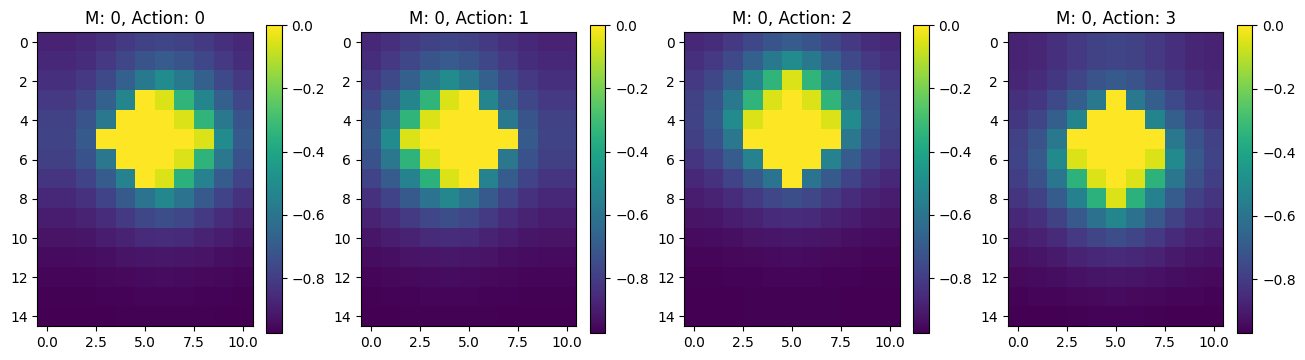

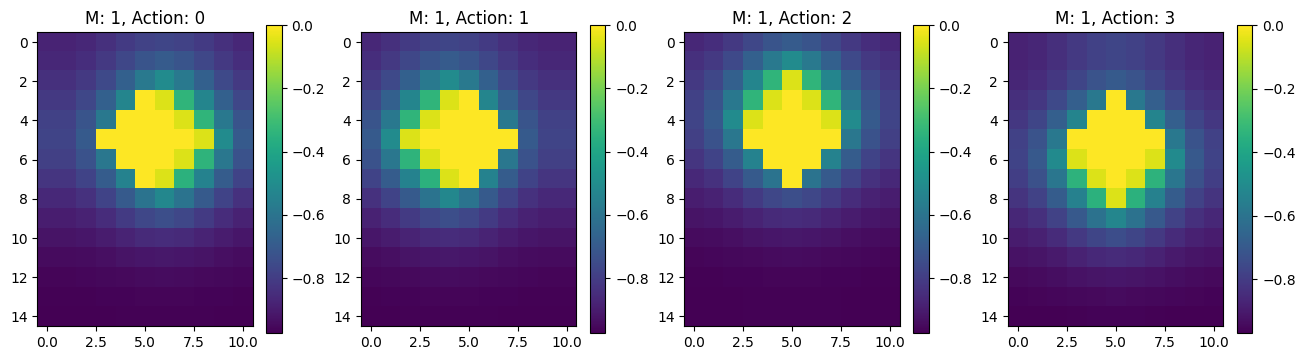

Diff between Q fortran in memory state 0 and 1
Action: 0 0.0
Action: 1 0.0
Action: 2 0.0
Action: 3 0.0


In [8]:
Q0 = create_random_Q0(Lx, Ly, Lx0, Ly0, gamma,a_size*M, M, cost_move, reward_find)

Q0 = Q0.flatten()
RR_fortran = average_reward_fortran(Lx,Ly,M,a_size,Lx0,Ly0,find_range,cost_move,reward_find)
RR_fortran = RR_fortran.flatten()
Q_fortran = itsolQ(pi, PObs_lim, gamma, RR_fortran, Q0, tol, Lx, Ly, Lx0, Ly0, find_range, cost_move)

Q_fortran = Q_fortran.reshape((M,Ly,Lx,M,a_size))

print('Q fortran shape', Q_fortran.shape)
for i in range(M):
    fig = plt.figure(figsize=(16,4))
    for j in range(a_size):
        plt.subplot(1,a_size,j+1)
        plt.title("M: {}, Action: {}".format(i,j))
        plt.imshow(Q_fortran[0,:,:,i,j])
        plt.colorbar()

    plt.show()

# Diff between Q in memory state 0 and 1
print("Diff between Q fortran in memory state 0 and 1")
_ = [print("Action:",j,np.sum(np.abs(Q_fortran[0,:,:,0,j]-Q_fortran[0,:,:,1,j]))) for j in range(a_size)]



Diff between Q fortran vs inverse
Memory state: 0, Action: 0, Diff: 0.0002470270435713795
    Inv min: -0.974839426659073, max: 0.0
Fortran min: -0.9748425988321382, max: 0.0


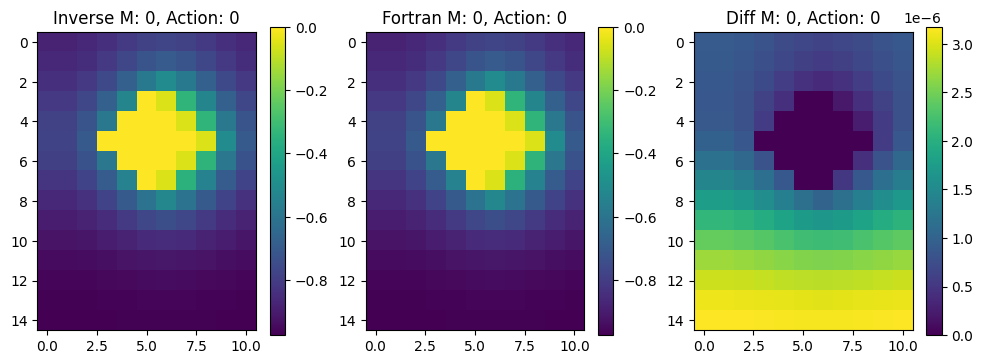

Memory state: 0, Action: 1, Diff: 0.0002470270435709354
    Inv min: -0.9748394266590723, max: 0.0
Fortran min: -0.9748425988321382, max: 0.0


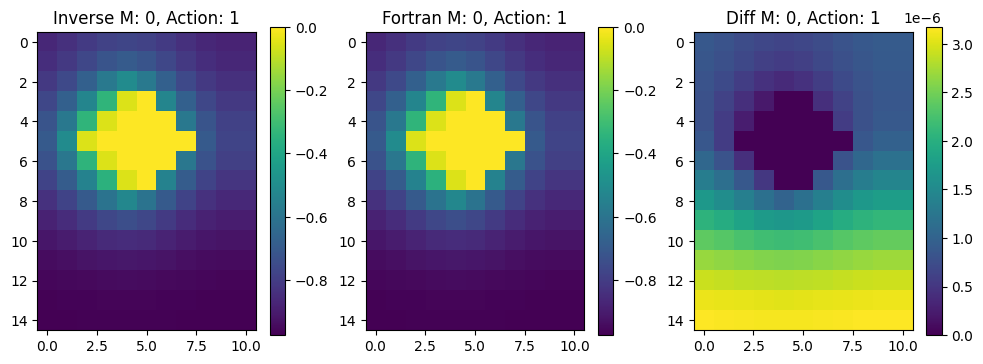

Memory state: 0, Action: 2, Diff: 0.0002720500902761436
    Inv min: -0.974839426659073, max: 0.0
Fortran min: -0.9748425988321382, max: 0.0


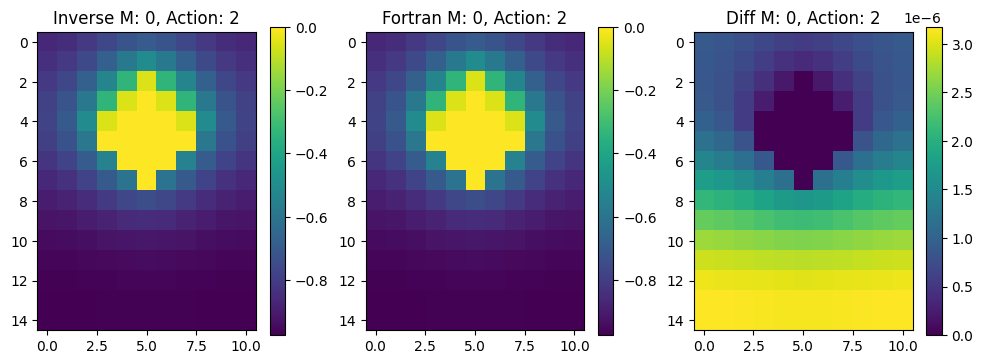

Memory state: 0, Action: 3, Diff: 0.00022174533688162912
    Inv min: -0.970465079080992, max: 0.0
Fortran min: -0.9704681703453224, max: 0.0


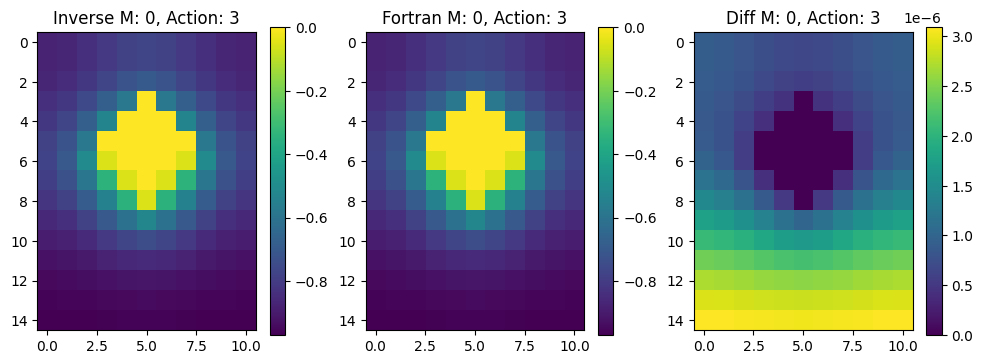

Memory state: 1, Action: 0, Diff: 0.0002470270435728228
    Inv min: -0.9748394266590732, max: 0.0
Fortran min: -0.9748425988321382, max: 0.0


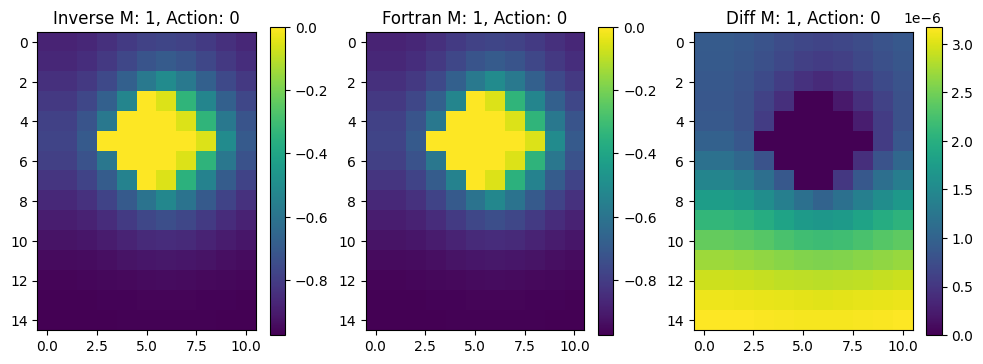

Memory state: 1, Action: 1, Diff: 0.0002470270435703248
    Inv min: -0.9748394266590722, max: 0.0
Fortran min: -0.9748425988321382, max: 0.0


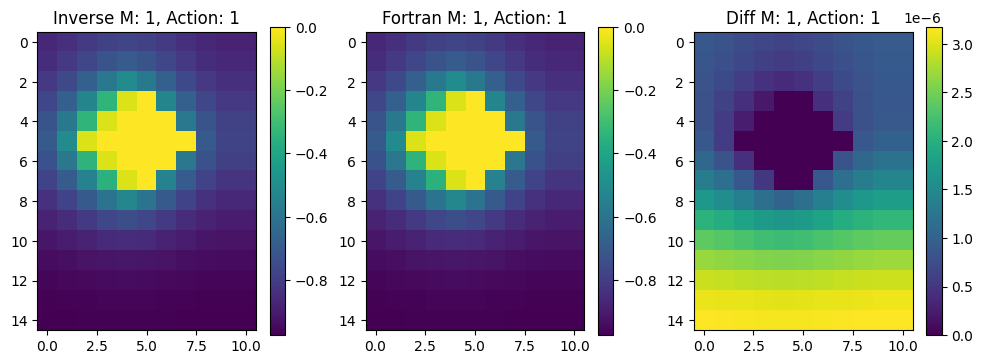

Memory state: 1, Action: 2, Diff: 0.00027205009027708726
    Inv min: -0.9748394266590732, max: 0.0
Fortran min: -0.9748425988321382, max: 0.0


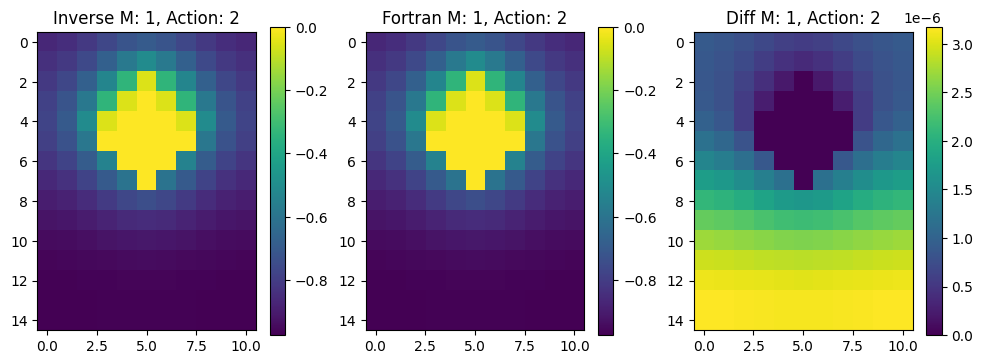

Memory state: 1, Action: 3, Diff: 0.00022174533688185116
    Inv min: -0.9704650790809916, max: 0.0
Fortran min: -0.9704681703453224, max: 0.0


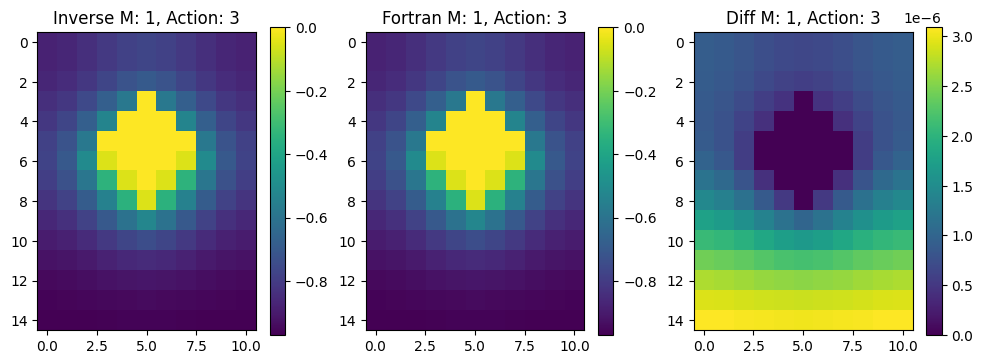

In [9]:
# Compare Q fortran vs inverse
print("Diff between Q fortran vs inverse")
for i in range(M):
    for j in range(a_size):
        print("Memory state: {}, Action: {}, Diff: {}".format(i,j,np.sum(np.abs(Q[0,:,:,i,j]-Q_fortran[0,:,:,i,j]))))
        print("    Inv min: {}, max: {}".format(np.min(Q[0,:,:,i,j]), np.max(Q[0,:,:,i,j])))
        print("Fortran min: {}, max: {}".format(np.min(Q_fortran[0,:,:,i,j]), np.max(Q_fortran[0,:,:,i,j])))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Inverse M: {}, Action: {}".format(i,j))
        plt.imshow(Q[0,:,:,i,j])
        plt.colorbar()
        plt.subplot(1,3,2)
        plt.title("Fortran M: {}, Action: {}".format(i,j))
        plt.imshow(Q_fortran[0,:,:,i,j])
        plt.colorbar()
        plt.subplot(1,3,3)
        plt.title("Diff M: {}, Action: {}".format(i,j))
        plt.imshow(np.abs(Q[0,:,:,i,j]-Q_fortran[0,:,:,i,j]))
        plt.colorbar()
        plt.show()

3.2097090263897947e-06


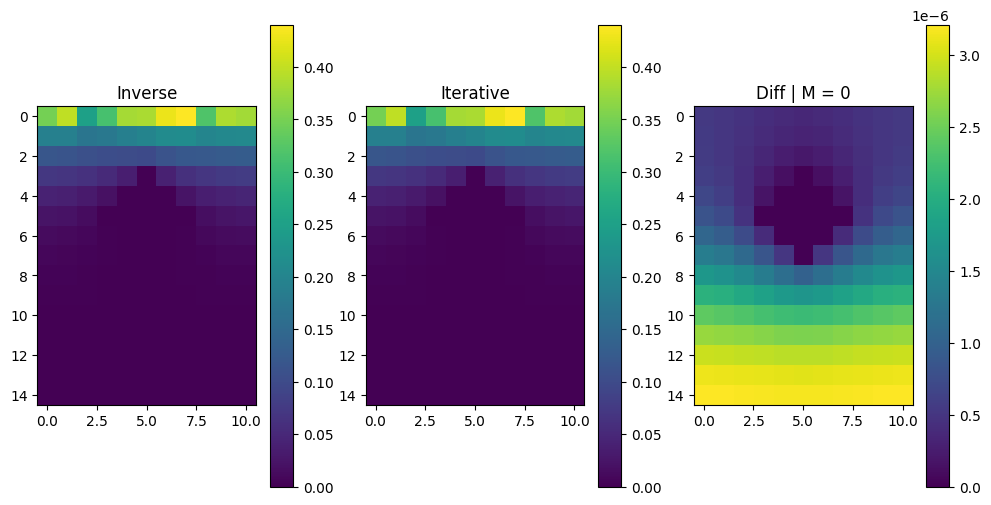

3.209709026389903e-06


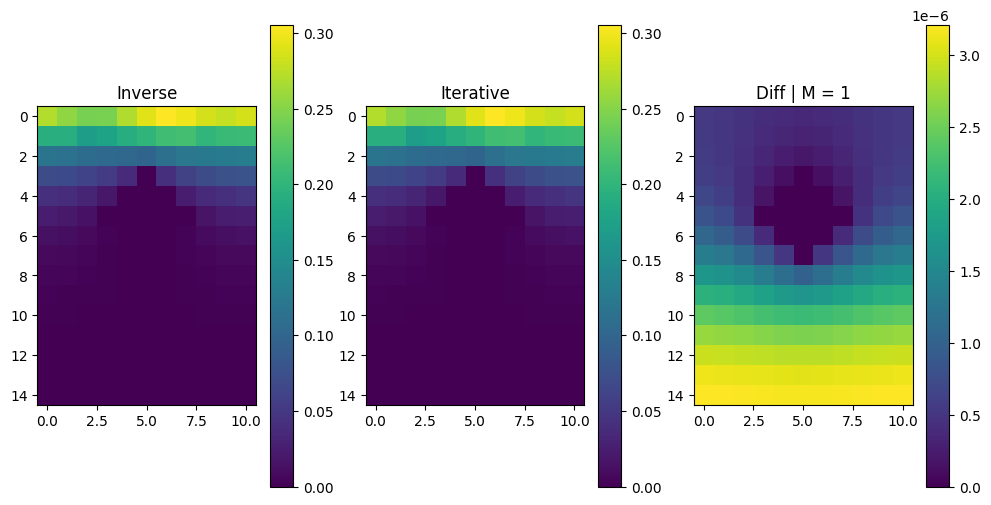

In [10]:
for im in range(M):
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.title("Inverse")
    plt.imshow(inv_sol.reshape(M,Ly,Lx)[im])
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title("Iterative")
    plt.imshow(iter_sol.reshape(M,Ly,Lx)[im])
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("Diff | M = {}".format(im))
    plt.imshow(np.abs(iter_sol.reshape(M,Ly,Lx)[im]-inv_sol.reshape(M,Ly,Lx)[im]))
    plt.colorbar()
    print(np.abs(iter_sol.reshape(M,Ly,Lx)[im]-inv_sol.reshape(M,Ly,Lx)[im]).max())
    

    plt.show()
